In [1]:
#check the efficiency on different tensors cigkl stiffness tensor, sometimes the order of the index affect the efficiency of the compressness (didnt do prrLU on it) maybe due to some other TCI method choice?
import math
import itertools
import random
import numpy as np
from dataclasses import dataclass
from typing import Callable, List, Sequence, Tuple, Optional

Array = np.ndarray


# ----------------------------
# TT core utilities
# ----------------------------

def tt_random_cores(dims: Sequence[int], ranks: Sequence[int], seed: int = 0) -> List[Array]:
    """
    Create random TT cores with shapes (r_{k-1}, n_k, r_k).
    ranks must have length= number of legs+1 with ranks[0]=ranks[-1]=1.
    """
    rng = np.random.default_rng(seed)
    N = len(dims)
    assert len(ranks) == N + 1 #Number of ranks (since the first core need 0th rank as well)
    assert ranks[0] == 1 and ranks[-1] == 1
    cores = []
    for k, n in enumerate(dims): #enumerate loop through each leg automatically and create N cores
        rL, rR = ranks[k], ranks[k+1]
        cores.append(rng.standard_normal((rL, n, rR))) #the 3D array core
    return cores


def tt_eval_entry(cores: List[Array], index: Sequence[int]) -> float:
    """
    Evaluate a single tensor entry given TT cores at a multi-index.
    index length must equal number of cores.
    """
    N = len(cores)
    assert len(index) == N
    v = cores[0][0, index[0], :]          # (r1,) v is the current dimension of the matrix slice multiplication, equal to the rank of current SVD matrix
    for k in range(1, N-1):
        v = v @ cores[k][:, index[k], :]  # from kth core we fix index of the input sigma_k and get 2D slice (r_{k+1},)
    v = v @ cores[-1][:, index[-1], 0]    # scalar
    return float(v)


def tt_contract_all(cores: List[Array]) -> Array:
    """
    Materialize full tensor from TT cores (only for small dims).
    Returns ndarray with shape dims.
    """
    N = len(cores)
    dims = [G.shape[1] for G in cores]
    # Start with first core: shape (n1, r1)
    X = cores[0][0, :, :]  # (n1, r1)
    for k in range(1, N):
        G = cores[k]  # (rL, nk, rR)
        # Contract X (..., rL) with G (rL, nk, rR) -> (..., nk, rR)
        X = np.tensordot(X, G, axes=([-1], [0]))
        # Now X shape: (*prev_dims, nk, rR)
    # Final rank should be 1
    assert X.shape[-1] == 1
    return np.squeeze(X, axis=-1)  # shape dims



# ----------------------------
# Tensor Oracle interface
# ----------------------------

@dataclass
class TensorOracle:
    dims: Tuple[int, ...] #store dim as tuple of integers
    entry: Callable[[Tuple[int, ...]], float]
    n_calls: int = 0

    def __call__(self, idx: Sequence[int]) -> float:
        self.n_calls += 1
        idx = tuple(int(i) for i in idx) # convert the input indices for each leg to tuple for oracle to evaluate
        return self.entry(idx)

    def reset_counter(self):
        self.n_calls = 0


    def block(self,
              I_left: Sequence[Tuple[int, ...]],
              S_mid: Sequence[Tuple[int, ...]],
              J_right: Sequence[Tuple[int, ...]]) -> Array:
        """
        Evaluate a sampled block:
          F(I_left, S_mid, J_right)
        where each element of I_left and J_right is a multi-index prefix/suffix.

        - I_left: list of length m, each a tuple of length (k-1)
        - S_mid : list of physical indices tuples for the middle modes (usually 1 or 2 legs)
        - J_right: list of length p, each a tuple of length (N-k) etc.

        Returns array of shape (m, |S_mid|, p)
        """
        m, s, p = len(I_left), len(S_mid), len(J_right)
        out = np.empty((m, s, p), dtype=float) #create a 3D array of such ashape
        for a, il in enumerate(I_left):
            for b, sm in enumerate(S_mid):
                for c, jr in enumerate(J_right):
                    idx = il + sm + jr
                    out[a, b, c] = self(idx)   #generate all combinations of indices at (a,b,c) with indice sets (il, sm, jr)
        return out


def oracle_from_tt(cores: List[Array]) -> TensorOracle:
    dims = tuple(G.shape[1] for G in cores) # collect second dimension of each core=dimension of each leg into a tuple
    def _entry(idx: Tuple[int, ...]) -> float:
        return tt_eval_entry(cores, idx) # takes a list/tuple of indices as input and returns the tensor entry value ny calling tt_eval
    return TensorOracle(dims=dims, entry=_entry)


# ----------------------------
# Quick sanity test
# ----------------------------

dims = (3, 3, 5, 3, 4)
ranks = (1, 2, 3, 2, 2, 1)  # TT ranks
gt_cores = tt_random_cores(dims, ranks, seed=42)
F = oracle_from_tt(gt_cores)

# test a random entry
print("F(0,1,4,3,1) =", F((0,1,4,2,1)))

# materialize full tensor for small dims and compare
full = tt_contract_all(gt_cores)
print("Full tensor shape:", full.shape)
print("Check same entry:", full[0,1,2,0])
max_diff = 0.0
for _ in range(20):
    idx = tuple(np.random.randint(0, d) for d in dims)
    diff = abs(F(idx) - full[idx])
    max_diff = max(max_diff, diff)

print("Max abs diff (20 samples):", max_diff)

F(0,1,4,3,1) = -0.929950820613756
Full tensor shape: (3, 3, 5, 3, 4)
Check same entry: [-0.71930919 -0.74070191  0.2209855   0.0622245 ]
Max abs diff (20 samples): 8.881784197001252e-16


In [2]:
import time
import numpy as np

def benchmark_entry_methods_safe(
    N_list=(4, 6, 8, 10, 11, 12),
    n=6,
    r=8,
    n_queries=5000,
    seed=0,
    ram_gb=16,
    safety_fraction=0.12,   # only use at most 12% of RAM for dense tensor itself
    dense_dtype=np.float64, # try np.float32 if you want to go a bit further
):
    rng = np.random.default_rng(seed)
    dtype_bytes = np.dtype(dense_dtype).itemsize

    results = []
    for N in N_list:
        dims = (n,) * N
        ranks = (1,) + (r,) * (N - 1) + (1,)

        cores = tt_random_cores(dims, ranks, seed=seed + N)
        F = oracle_from_tt(cores)

        queries = [tuple(rng.integers(0, n, size=N).tolist()) for _ in range(n_queries)]

        # TT eval timing
        t0 = time.perf_counter()
        acc_tt = 0.0
        for q in queries:
            acc_tt += F(q)
        t1 = time.perf_counter()
        tt_total = t1 - t0
        tt_us = 1e6 * tt_total / n_queries

        # Dense feasibility check
        num_elems = int(np.prod(dims))
        dense_bytes = num_elems * dtype_bytes
        dense_gb = dense_bytes / (1024**3)

        ram_bytes = ram_gb * (1024**3)
        allow_dense = dense_bytes <= safety_fraction * ram_bytes

        dense_build = None
        dense_index = None
        ix_us = None
        k_star = None

        if allow_dense:
            t2 = time.perf_counter()
            full = tt_contract_all(cores).astype(dense_dtype, copy=False)
            t3 = time.perf_counter()
            dense_build = t3 - t2

            t4 = time.perf_counter()
            acc_ix = 0.0
            for q in queries:
                acc_ix += full[q]
            t5 = time.perf_counter()
            dense_index = t5 - t4
            ix_us = 1e6 * dense_index / n_queries

            # break-even queries
            denom = (tt_us - ix_us) * 1e-6  # seconds/query
            if denom > 0:
                k_star = dense_build / denom

        if dense_build is not None:
            print(
                f"N={N}, elems={num_elems:,}, dense~{dense_gb:.3f} GB ({dense_dtype.__name__}): "
                f"TT {tt_us:.2f} us/q; build {dense_build:.3f} s; index {ix_us:.2f} us/q; "
                f"break-even ~{k_star:.0f} queries"
            )
        else:
            print(
                f"N={N}, elems={num_elems:,}, dense~{dense_gb:.3f} GB ({dense_dtype.__name__}): "
                f"TT {tt_us:.2f} us/q; dense skipped (safety cap)"
            )

        results.append((N, num_elems, dense_gb, tt_us, dense_build, ix_us, k_star))

    return results
results = benchmark_entry_methods_safe(
    N_list=(4, 6, 8, 10),
    n=6,
    r=8,
    n_queries=5000,
    ram_gb=16,
    safety_fraction=0.10,
    dense_dtype=np.float64
)

N=4, elems=1,296, dense~0.000 GB (float64): TT 12.02 us/q; build 0.000 s; index 0.25 us/q; break-even ~14 queries
N=6, elems=46,656, dense~0.000 GB (float64): TT 17.28 us/q; build 0.002 s; index 0.48 us/q; break-even ~105 queries
N=8, elems=1,679,616, dense~0.013 GB (float64): TT 25.67 us/q; build 0.016 s; index 0.56 us/q; break-even ~642 queries
N=10, elems=60,466,176, dense~0.451 GB (float64): TT 31.37 us/q; build 0.560 s; index 0.69 us/q; break-even ~18255 queries


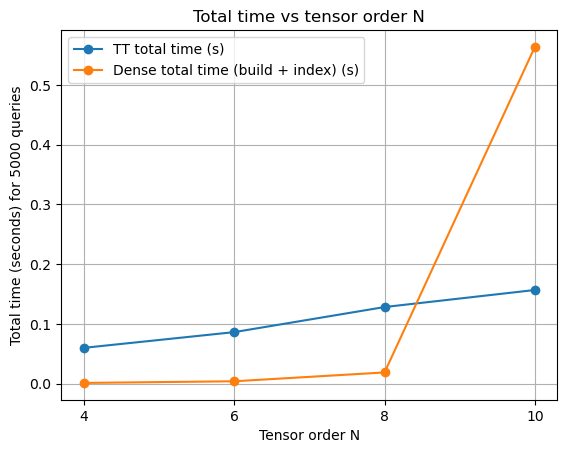

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n_queries = 5000  # must match the benchmark call

# tuple layout: (N, num_elems, dense_gb, tt_us_per_q, dense_build_s, dense_index_us_per_q, k_star)
N = np.array([row[0] for row in results], dtype=int)
tt_us_per_q = np.array([row[3] for row in results], dtype=float)
dense_build_s = np.array([np.nan if row[4] is None else row[4] for row in results], dtype=float)
dense_index_us_per_q = np.array([np.nan if row[5] is None else row[5] for row in results], dtype=float)

tt_total_s = tt_us_per_q * 1e-6 * n_queries
dense_total_s = dense_build_s + dense_index_us_per_q * 1e-6 * n_queries

plt.figure()
plt.plot(N, tt_total_s, marker="o", label="TT total time (s)")
plt.plot(N, dense_total_s, marker="o", label="Dense total time (build + index) (s)")
plt.xlabel("Tensor order N")
plt.ylabel(f"Total time (seconds) for {n_queries} queries")
plt.title("Total time vs tensor order N")
plt.xticks(N)
plt.grid(True)
plt.legend()
plt.show()

the result matches our theoretical estimation individually
\[
\begin{aligned}
\text{TT entry evaluation:} \quad & O(N r^2), \\
\text{Full tensor evaluation from cores:} \quad & O(r^2 n^N), \\
\end{aligned}
\]
However for small Ns In real Python/NumPy code, a TT entry evaluation performs $N$ repeated steps where each step (1) runs a Python loop iteration, (2) performs NumPy slicing (which creates a view object, performs bounds and stride bookkeeping, and may occasionally trigger small memory copies depending on layout), and (3) executes a very small BLAS-like multiplication on tiny arrays (e.g., $8 \times 8$), where the cost is dominated by function-call and setup overhead rather than floating-point operations. 

Dense construction is cheap for small $N$ because the tensor being built contains only $n^N$ entries, and when $N$ is small this number remains modest. With $n=6$, we have $6^4 = 1{,}296$, $6^6 = 46{,}656$, and $6^8 \approx 1.68 \times 10^6$, which corresponds to only about $13\,\text{MB}$ in double precision. In this regime, constructing the dense tensor mainly consists of a moderate amount of contraction work followed by writing a relatively small contiguous block of memory. Modern CPUs and NumPy are highly optimized for streaming and initializing contiguous arrays of this size, so the one-time construction cost is typically on the order of milliseconds or less.

In [5]:
def prrlu_complete_pivot_LDU(
    A: np.ndarray,
    rmax: int,
    eps: float = 1e-12,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: #need 7 outputs, row col indices, row permutation matrix and col premutation matix, L,D and U 
    """
    Complete-pivoting rank-revealing LU, returned explicitly as L D U1.

    Produces:
        Pr @ A @ Pc ≈ L @ D @ U1

    Shapes:
        L  : (m, r)  unit-lower (rectangular)
        D  : (r, r)  diagonal (pivots)
        U1 : (r, n)  unit-upper in first r columns (rectangular)
    """
    Awork = np.array(A, dtype=float, copy=True) # do a copy of the input matrix so we don't modify it
    m, n = Awork.shape
    rmax = min(rmax, m, n)

    prow = np.arange(m) #tracks the current ordering of rows, expressed in original row labels, updated whenever rows are swapped
    pcol = np.arange(n) # same for cols 

    piv_rows = []
    piv_cols = []

    pivot0 = None
    r = 0 #prrLU steps, also the rank
    # We'll store pivots (diagonal D) as a vector first, then make diag matrix.
    d_list = []
    
    for k in range(rmax):
        # Find largest pivot in submatrix starting at row/col k
        sub = np.abs(Awork[k:, k:])
        i_rel, j_rel = np.unravel_index(np.argmax(sub), sub.shape) #argmax to find largest element in sub matrix and use unravel to find its index
        i = k + i_rel #true indices in the big matrix 
        j = k + j_rel
        piv = Awork[i, j] #read the element value at pivot since we need it as stopping criterion and to vide the col/row by 

        if pivot0 is None:
            pivot0 = abs(piv) if abs(piv) != 0 else 1.0 #Store scale as the magnitude of the first pivot. If the first pivot is zero (degenerate), use 1.0 to avoid multiplying by zero later.

        if abs(piv) <= eps * pivot0:
            break #stop if the remaining pivot is tiny compared to matrix scale 

        # Swap rows/cols to move pivot to (k,k)
        if i != k:                                  #if i is not equal to k
            Awork[[k, i], :] = Awork[[i, k], :]     #for kth and ith row and all columns
            prow[[k, i]] = prow[[i, k]]             # swap i to k 
        if j != k:
            Awork[:, [k, j]] = Awork[:, [j, k]]
            pcol[[k, j]] = pcol[[j, k]]

        piv_rows.append(prow[k])
        piv_cols.append(pcol[k]) #pivot is now at (k,k) tge true original indices are prow[k] and pcol[k]

        pivot = Awork[k, k]
        if pivot == 0:
            break

        d_list.append(pivot) #add the pivot element to the list of ds and later turn it into matrix D 

        # 3) compute L multipliers below pivot: L[i,k] = A[i,k] / pivot
        if k + 1 < m:
            Awork[k+1:, k] /= pivot # for rows k+1 to the end and col k we divide by pivot to later store in L matrix 

        # 4) normalize pivot row to become U1 row:
        #    U1[k, j] = A[k, j] / pivot, for j >= k
        Awork[k, k:] /= pivot #same for U matrix but all cols
        # Now Awork[k,k] should be 1 (unit diagonal for U1)
        Awork[k, k] = 1.0

        # 5) Schur complement update:
        #    A22 -= L21 * (Dk * U1_12)
        # Here:
        #   L21 is Awork[k+1:, k]
        #   U1_12 is Awork[k, k+1:]
        #   Dk is pivot
        if (k + 1 < m) and (k + 1 < n): #not at the last row or col
            Awork[k+1:, k+1:] -= np.outer(Awork[k+1:, k], pivot * Awork[k, k+1:])#left is matrix A_22 the schur complement right is L21-U12, basically the formula for schur update A/[A_11]=(lower trig of L)D(upper trig of U)

        r += 1

    # Build outputs
    piv_rows = np.array(piv_rows, dtype=int)
    piv_cols = np.array(piv_cols, dtype=int)

    # Permutation matrices (debugging)
    Pr = np.eye(m)[np.argsort(prow)]
    Pc = np.eye(n)[:, np.argsort(pcol)] #check to see if LDU is equal to Pr A Pc

    if r == 0:
        L = np.zeros((m, 0))
        D = np.zeros((0, 0))
        U1 = np.zeros((0, n))
        return piv_rows, piv_cols, Pr, Pc, L, D, U1 #prrLU failed

    # Extract L (unit-lower) from Awork: below diag in first r columns + identity
    L = np.tril(Awork[:, :r], k=-1) + np.eye(m, r)

    # Extract U1 (unit-upper) from Awork: first r rows, upper-triangular-ish
    # Since we normalized pivot rows, Awork already stores U1 in those rows.
    U1 = np.triu(Awork[:r, :], k=0)

    # Build D
    D = np.diag(np.array(d_list, dtype=float))

    return piv_rows, piv_cols, Pr, Pc, L, D, U1
def skeleton_approx_from_pivots(A: np.ndarray, piv_rows: np.ndarray, piv_cols: np.ndarray, reg: float = 0.0):
    """
    Given pivot rows/cols, form a CI approximation:
        A ≈ A[:,J] @ inv(A[I,J]) @ A[I,:]

    Returns:
        A_hat
    """
    I, J = piv_rows, piv_cols
    C = A[:, J]                 # m x r
    R = A[I, :]                 # r x n
    P = A[np.ix_(I, J)]         # r x r

    if reg > 0:
        P = P + reg * np.eye(P.shape[0])
    X = np.linalg.solve(P, R)   # r x n
    return C @ X

# ----------------------------
# Quick test of CI on a random matrix
# ----------------------------
rng = np.random.default_rng(0)
A = rng.integers(-5, 6, size=(30, 40)).astype(float)


piv_r, piv_c, Pr, Pc, L, D, U1 = prrlu_complete_pivot_LDU(A, rmax=8, eps=1e-12)


print("Selected rank r =", len(piv_r))
print("First few pivot rows:", piv_r[:5])
print("First few pivot cols:", piv_c[:5])

# Check reconstruction quality of permuted LU: Pr*A*Pc ≈ L*U
A_perm = Pr @ A @ Pc
if len(piv_r) > 0:
    rel_err = np.linalg.norm(A_perm - L @ D @ U1) / np.linalg.norm(A_perm)
    print("Relative LU factorization error:", rel_err)

# Check skeleton approximation error using the same pivots       cigkl stiffness tensor
if len(piv_r) > 0:
    A_hat = skeleton_approx_from_pivots(A, piv_r, piv_c)
    rel_err_skel = np.linalg.norm(A - A_hat) / np.linalg.norm(A) #entry difference then do root mean square and normalised
    print("Relative skeleton approx error:", rel_err_skel)

# --- isotropic stiffness tensor: C_ijkl = lam δij δkl + mu(δik δjl + δil δjk)
def C_isotropic(i, j, k, l, lam=2.0, mu=1.0):
    dij = 1.0 if i == j else 0.0
    dkl = 1.0 if k == l else 0.0
    dik = 1.0 if i == k else 0.0
    djl = 1.0 if j == l else 0.0
    dil = 1.0 if i == l else 0.0
    djk = 1.0 if j == k else 0.0
    return lam * dij * dkl + mu * (dik * djl + dil * djk)

# Build a 30x40 matrix by mapping each row->(i,j) and each col->(k,l)
pairs = [(a,b) for a in range(3) for b in range(3)]  # 9 pairs since 3 index choices (maximum rank = 9 since the matrix is 9*9 the rest are all linearly dependent)

rng = np.random.default_rng(0)  # keep deterministic like your random test
row_pairs = rng.choice(len(pairs), size=30, replace=True)
col_pairs = rng.choice(len(pairs), size=40, replace=True)

A_stiff = np.empty((30, 40), dtype=float)
for r in range(30):
    i, j = pairs[row_pairs[r]]
    for c in range(40):
        k, l = pairs[col_pairs[c]]
        A_stiff[r, c] = C_isotropic(i, j, k, l, lam=2.0, mu=1.0)

# --- Run the same PRR-LU + skeleton as your random test
piv_r_s, piv_c_s, Pr_s, Pc_s, L_s, D_s, U1_s = prrlu_complete_pivot_LDU(A_stiff, rmax=8, eps=1e-12)

print("\n--- Stiffness-derived matrix test (same size 30x40, same rmax as the rng tensor) ---")
print("Selected rank r =", len(piv_r_s))
print("First few pivot rows:", piv_r_s[:5])
print("First few pivot cols:", piv_c_s[:5])

A_perm_s = Pr_s @ A_stiff @ Pc_s
if len(piv_r_s) > 0:
    rel_err_lu_s = np.linalg.norm(A_perm_s - L_s @ D_s @ U1_s) / np.linalg.norm(A_perm_s)
    print("Relative LU factorization error:", rel_err_lu_s)

    Ahat_s = skeleton_approx_from_pivots(A_stiff, piv_r_s, piv_c_s)
    rel_err_skel_s = np.linalg.norm(A_stiff - Ahat_s) / np.linalg.norm(A_stiff)
    print("Relative skeleton approx error:", rel_err_skel_s)

print("Matrix rank (numerical):", np.linalg.matrix_rank(A_stiff))
print("A_stiff shape:", A_stiff.shape)

print("Pr_s shape:", Pr_s.shape, "Pc_s shape:", Pc_s.shape)

print("L_s shape:", L_s.shape)
print("D_s shape:", D_s.shape)
print("U1_s shape:", U1_s.shape)

print("len(piv_r_s):", len(piv_r_s), "len(piv_c_s):", len(piv_c_s))


Selected rank r = 8
First few pivot rows: [ 0  3 14 22 11]
First few pivot cols: [ 5 23 32 12 14]
Relative LU factorization error: 1.2821887425854746
Relative skeleton approx error: 1.0205740454317986

--- Stiffness-derived matrix test (same size 30x40, same rmax as the rng tensor) ---
Selected rank r = 6
First few pivot rows: [ 2  5 11  3  1]
First few pivot cols: [ 5  2 23  7  0]
Relative LU factorization error: 0.7265575424673621
Relative skeleton approx error: 0.0
Matrix rank (numerical): 6
A_stiff shape: (30, 40)
Pr_s shape: (30, 30) Pc_s shape: (40, 40)
L_s shape: (30, 6)
D_s shape: (6, 6)
U1_s shape: (6, 40)
len(piv_r_s): 6 len(piv_c_s): 6


In [6]:
import  hashlib

MultiIndex = Tuple[int, ...]
def two_site_block_matrix(F: TensorOracle, I_left: List[MultiIndex], k: int, J_right: List[MultiIndex]) -> np.ndarray:
    """
    Build the 2-site sampled block:
        Π_k = F(I_{k-1}, sigma_k, sigma_{k+1}, J_{k+2})

    where:
      - I_left contains multi-indices of length k-1
      - J_right contains multi-indices of length N-(k+1)
      - k is 1-based site index in math; here we'll use 0-based Python index for cores.

    Returns Π as a 2D matrix with shape:
      rows = |I_left| * n_k
      cols = n_{k+1} * |J_right|
    """
    N = len(F.dims)
    assert 0 <= k <= N-2
    """
    sites are 0..N-1
      this function builds the block for sites k and k+1 (so requires k <= N-2)
      """
    n_k = F.dims[k]
    n_kp1 = F.dims[k+1]

    # Build lists of middle index tuples for the pair of the two free legs, same as two for loops
    S_mid = [(s1, s2) for s1 in range(n_k) for s2 in range(n_kp1)]  # length n_k*n_{k+1}

    # Query the oracle for the 3D block of shape (|I_left|, n_k*n_{k+1}, |J_right|)
    block3 = F.block(I_left=I_left, S_mid=S_mid, J_right=J_right)

    # Now reshape into a matrix with:
    #   rows = |I_left| * n_k
    #   cols = n_{k+1} * |J_right|
    #
    # block3 is indexed by:
    #   block3[a, b, c]
    # where b corresponds to (sigma_k, sigma_{k+1}) in S_mid order.
    #
    # We'll reshape by first reshaping the middle axis into (n_k, n_{k+1}):
    m = len(I_left)
    p = len(J_right)
    block4 = block3.reshape(m, n_k, n_kp1, p)          # (m, n_k, n_{k+1}, p)
    A = block4.reshape(m * n_k, n_kp1 * p)             # (m*n_k, n_{k+1}*p)
    return A # The 2D matrix for prrLU


# ---------- helpers ----------
def skeleton_from_pivots(A, piv_r, piv_c, rcond=1e-12):
    """
    CUR / skeleton: A_hat = A[:,J] * pinv(A[I,J]) * A[I,:]
    Uses pseudoinverse for stability.
    """
    if len(piv_r) == 0:
        return np.zeros_like(A)
    C = A[:, piv_c]
    R = A[piv_r, :]
    U = A[np.ix_(piv_r, piv_c)]
    Uinv = np.linalg.pinv(U, rcond=rcond)
    return C @ Uinv @ R


def random_multi_indices(dims, r, seed=0):
    rng = np.random.default_rng(seed)
    if len(dims) == 0:
        all_idx = [tuple()]
    else:
        all_idx = list(itertools.product(*[range(d) for d in dims]))
    rng.shuffle(all_idx)
    return all_idx[:r]


# ---------- stiffness tensor oracle (isotropic) ----------
def C_isotropic_entry(idx, lam=2.0, mu=1.0):
    """
    C_{ijkl} = lam * δ_ij δ_kl + mu * (δ_ik δ_jl + δ_il δ_jk)
    with i,j,k,l in {0,1,2}.
    """
    i, j, k, l = idx
    dij = 1.0 if i == j else 0.0
    dkl = 1.0 if k == l else 0.0
    dik = 1.0 if i == k else 0.0
    djl = 1.0 if j == l else 0.0
    dil = 1.0 if i == l else 0.0
    djk = 1.0 if j == k else 0.0
    return lam * dij * dkl + mu * (dik * djl + dil * djk)


F_stiff = TensorOracle(
    dims=(3,3,3,3),
    entry=lambda idx: C_isotropic_entry(idx, lam=2.0, mu=1.0)
)


# ---------- deterministic IID-random tensor oracle (full-rank-ish) ----------
def det_randn(idx, seed=0):
    """
    Deterministic N(0,1) from (seed, idx) using Box-Muller.
    """
    b = hashlib.blake2b((str(seed) + str(idx)).encode(), digest_size=16).digest()
    u1 = (int.from_bytes(b[:8],  'little') + 1) / (2**64 + 2)  # (0,1)
    u2 = (int.from_bytes(b[8:],  'little') + 1) / (2**64 + 2)
    z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
    return float(z)

F_iid = TensorOracle(
    dims=(3,3,3,3),
    entry=lambda idx: det_randn(idx, seed=123)
)


# ---------- build the SAME local 2-site block A for both ----------
k = 1  # same as your demo: block for sites (k, k+1) = (1,2) with 0-based indexing

I_left  = random_multi_indices(F_stiff.dims[:k], r=3, seed=1)
J_right = random_multi_indices(F_stiff.dims[k+2:], r=3, seed=2)

F_stiff.reset_counter()
A_stiff = two_site_block_matrix(F_stiff, I_left, k, J_right)
calls_stiff = F_stiff.n_calls

F_iid.reset_counter()
A_iid   = two_site_block_matrix(F_iid, I_left, k, J_right)
calls_iid = F_iid.n_calls

print("A shape:", A_stiff.shape)
print("Oracle calls (stiff):", calls_stiff, " | (iid):", calls_iid)
print("Matrix ranks:  stiff =", np.linalg.matrix_rank(A_stiff), " | iid =", np.linalg.matrix_rank(A_iid))


# ---------- compare prrLU skeleton error vs rmax ----------
def rel_skeleton_error(A, rmax):
    piv_r, piv_c, *_ = prrlu_complete_pivot_LDU(A, rmax=rmax, eps=1e-12)
    Ahat = skeleton_from_pivots(A, piv_r, piv_c)
    rel_err = np.linalg.norm(A - Ahat) / np.linalg.norm(A)
    return len(piv_r), rel_err

print("\nrmax | stiff_rank  stiff_relerr | iid_rank  iid_relerr")
print("-"*56)
for rmax in range(1, A_stiff.shape[0] + 1): #iteratively increase rmax to show the accuracy for both matrices
    rs, es = rel_skeleton_error(A_stiff, rmax)
    rr, er = rel_skeleton_error(A_iid, rmax)
    print(f"{rmax:4d} | {rs:10d}  {es:12.4e} | {rr:7d}  {er:10.4e}")

A shape: (9, 9)
Oracle calls (stiff): 81  | (iid): 81
Matrix ranks:  stiff = 6  | iid = 9

rmax | stiff_rank  stiff_relerr | iid_rank  iid_relerr
--------------------------------------------------------
   1 |          1    6.1721e-01 |       1  9.2306e-01
   2 |          2    4.7698e-01 |       2  8.6688e-01
   3 |          3    3.7796e-01 |       3  7.3031e-01
   4 |          4    3.0861e-01 |       4  6.3179e-01
   5 |          5    2.1822e-01 |       5  5.2522e-01
   6 |          6    1.0835e-16 |       6  4.4194e-01
   7 |          6    1.0835e-16 |       7  3.5291e-01
   8 |          6    1.0835e-16 |       8  2.3467e-01
   9 |          6    1.0835e-16 |       9  8.2177e-16


Logic: prrLU still requires the detail of all entries in a matrix therefore we choose sub matrix from the full matrix first and then apply prrLU
Testing: use random matrix to test the accuracy of algorithm just in case if the implimentation is not bugged

In [8]:


def decode_row_id(row_id: int, I_left: List[MultiIndex], n_k: int) -> MultiIndex:
    """
    To get the index of I after prrLU
    Row index in the reshaped 2-site matrix corresponds to (i_{k-1}, sigma_k).

    We pack rows as:
        row_id = a * n_k + sigma_k 
    where:
        a is index into I_left
        sigma_k in {0,...,n_k-1} a

    Returns the new left multi-index i_k = (i_{k-1}, sigma_k).
    """
    a = row_id // n_k
    """
    // used for integer division
    %for the remainder
    """
    sigma_k = row_id % n_k
    return I_left[a] + (sigma_k,)


def decode_col_id(col_id: int, J_right: List[MultiIndex], n_kp1: int) -> MultiIndex:
    """
    Column index corresponds to (sigma_{k+1}, j_{k+2}).

    We pack cols as:
        col_id = sigma_{k+1} * |J_right| + b
        (swap the ordering copared to row id, since for row id the sigma is on the right side and for col id sigma is on the left
    where:
        b is index into J_right
        sigma_{k+1} in {0,...,n_{k+1}-1}

    Returns new right multi-index j_{k+1} = (sigma_{k+1}, j_{k+2}).
    """
    R = len(J_right)
    sigma_kp1 = col_id // R
    b = col_id % R
    return (sigma_kp1,) + J_right[b]




# ----------------------------
# Demo: one local 2-site update
# ----------------------------

def random_multi_indices(dims, r):
    all_idx = list(itertools.product(*[range(d) for d in dims]))
    random.shuffle(all_idx)
    return all_idx[:r]

N = len(F.dims)
k = 1  # build block for sites 1 and 2 (0-based)

# Initialize very small pivot sets (path-based):

# For this local block, I_left should be length k (i.e. k sites on the left of site k since we start at k = 0)
# But in math it is I_{k-1}. For k=1 (sites 1&2), k-1=0 so I_left is empty prefix.
# for any k, we store multi-indices of length k (sites 0..k-1)
# and J_right of length N-(k+2) (sites k+2..N-1)
#
# We'll start with 3 random indices
I_left  = random_multi_indices(F.dims[:k], r=3) #first k tensor dimensions with three realisations (of 0,1,2) doesnt include kth 
J_right = random_multi_indices(F.dims[k+2:], r=3) #k+2th index to the end (include k+2th), also three realisations


F.reset_counter()
A = two_site_block_matrix(F, I_left, k, J_right) #construct sample matrix with I and J while loop over indices in two free legs

print("Built 2-site block matrix A with shape:", A.shape)
print("Oracle calls used to build A:", F.n_calls)
print("\n=== Decoding BEFORE pivot update ===")

n_k = F.dims[k]
n_kp1 = F.dims[k+1]

print("\nRow ID → tensor multi-index (prefix, σ_k):")
for rid in range(A.shape[0]):
    decoded = decode_row_id(rid, I_left, n_k)
    print(f"row {rid:2d} -> {decoded}")

print("\nCol ID → tensor multi-index (σ_{k+1}, suffix):")
for cid in range(A.shape[1]):
    decoded = decode_col_id(cid, J_right, n_kp1)
    print(f"col {cid:2d} -> {decoded}")

# Run prrLU on this small matrix
piv_r, piv_c, Pr, Pc, L, D, U1 = prrlu_complete_pivot_LDU(A, rmax=4, eps=1e-12) 

print("Local discovered rank r =", len(piv_r))
print("Pivot row ids (in A):", piv_r)
print("Pivot col ids (in A):", piv_c)

# Decode pivot ids into NEW multi-index sets
n_k = F.dims[k]
n_kp1 = F.dims[k+1]

I_k = [decode_row_id(rid, I_left, n_k) for rid in piv_r]          # multi-indices length k+1
J_kp1 = [decode_col_id(cid, J_right, n_kp1) for cid in piv_c]     # multi-indices length N-(k+1)

print("Updated I_k (prefix indices up to site k):", I_k)
print("Updated J_{k+1} (suffix indices from site k+1):", J_kp1)


Built 2-site block matrix A with shape: (9, 15)
Oracle calls used to build A: 135

=== Decoding BEFORE pivot update ===

Row ID → tensor multi-index (prefix, σ_k):
row  0 -> (2, 0)
row  1 -> (2, 1)
row  2 -> (2, 2)
row  3 -> (0, 0)
row  4 -> (0, 1)
row  5 -> (0, 2)
row  6 -> (1, 0)
row  7 -> (1, 1)
row  8 -> (1, 2)

Col ID → tensor multi-index (σ_{k+1}, suffix):
col  0 -> (0, 2, 2)
col  1 -> (0, 0, 1)
col  2 -> (0, 2, 3)
col  3 -> (1, 2, 2)
col  4 -> (1, 0, 1)
col  5 -> (1, 2, 3)
col  6 -> (2, 2, 2)
col  7 -> (2, 0, 1)
col  8 -> (2, 2, 3)
col  9 -> (3, 2, 2)
col 10 -> (3, 0, 1)
col 11 -> (3, 2, 3)
col 12 -> (4, 2, 2)
col 13 -> (4, 0, 1)
col 14 -> (4, 2, 3)
Local discovered rank r = 3
Pivot row ids (in A): [2 0 4]
Pivot col ids (in A): [ 1 12  9]
Updated I_k (prefix indices up to site k): [(2, 2), (2, 0), (0, 1)]
Updated J_{k+1} (suffix indices from site k+1): [(0, 0, 1), (4, 2, 2), (3, 2, 2)]


In [9]:
def show_set(name, S, max_items=10):
    print(f"{name} (len={len(S)}):", S[:max_items], ("..." if len(S) > max_items else ""))
def sweep_lr_2site(F, dims, I, J, rmax, eps=1e-12, debug=False):
    N = len(dims)
    for k in range(N-1):
        n_k, n_kp1 = dims[k], dims[k+1]
        I_left  = I[k]
        J_right = J[k+2] #same as before the block correspond to I[k] -- site k - site k+1 -- J[k+2]

        if debug:
            print("\n" + "="*70)
            print(f"L->R update at k={k} (sites {k},{k+1}), n_k={n_k}, n_k+1={n_kp1}")
            show_set("I_left", I_left)
            show_set("J_right", J_right) #print step info when debug appears

        A = two_site_block_matrix(F, I_left, k, J_right) #reshape to A and do prrLU to find the pivots
        piv_r, piv_c, *_ = prrlu_complete_pivot_LDU(A, rmax=rmax, eps=eps) # piv_r are the row numbers in matrix A therefore we need to decode it into tensor multi-index form

        if debug:
            print("A shape:", A.shape)
            print("piv_r:", piv_r)
            print("piv_c:", piv_c) #same as before

            # show decode details for each pivot
            print("Decode pivot rows -> new I[k+1]:")
            for rid in piv_r:
                a = int(rid) // n_k
                s = int(rid) % n_k
                print(f"  rid={rid:>4} -> a={a}, sigma_k={s}, I_left[a]={I_left[a]}  => {decode_row_id(int(rid), I_left, n_k)}")

            print("Decode pivot cols -> new J[k+1]:")
            R = len(J_right)
            for cid in piv_c:
                sig = int(cid) // R
                b   = int(cid) % R
                print(f"  cid={cid:>4} -> sigma_k+1={sig}, b={b}, J_right[b]={J_right[b]} => {decode_col_id(int(cid), J_right, n_kp1)}")

        new_I = [decode_row_id(int(rid), I_left, n_k) for rid in piv_r]
        new_J = [decode_col_id(int(cid), J_right, n_kp1) for cid in piv_c]

        # unique + truncate
        I[k+1] = list(dict.fromkeys(new_I))[:rmax]
        J[k+1] = list(dict.fromkeys(new_J))[:rmax]

        if debug:
            show_set("Updated I[k+1]", I[k+1])
            show_set("Updated J[k+1]", J[k+1])

    return I, J
def sweep_rl_2site(F, dims, I, J, rmax, eps=1e-12, debug=False):
    N = len(dims)
    for k in range(N-2, -1, -1):
        n_k, n_kp1 = dims[k], dims[k+1]
        I_left  = I[k]
        J_right = J[k+2]

        if debug:
            print("\n" + "="*70)
            print(f"R->L update at k={k} (sites {k},{k+1}), n_k={n_k}, n_k+1={n_kp1}")
            show_set("I_left", I_left)
            show_set("J_right", J_right)

        A = two_site_block_matrix(F, I_left, k, J_right)
        piv_r, piv_c, *_ = prrlu_complete_pivot_LDU(A, rmax=rmax, eps=eps)

        if debug:
            print("A shape:", A.shape)
            print("piv_r:", piv_r)
            print("piv_c:", piv_c)

        new_I = [decode_row_id(int(rid), I_left, n_k) for rid in piv_r]
        new_J = [decode_col_id(int(cid), J_right, n_kp1) for cid in piv_c]

        I[k+1] = list(dict.fromkeys(new_I))[:rmax]
        J[k+1] = list(dict.fromkeys(new_J))[:rmax]

        if debug:
            show_set("Updated I[k+1]", I[k+1])
            show_set("Updated J[k+1]", J[k+1])

    return I, J

def pivots_signature(I, J):
    return tuple(tuple(x) for x in I) + tuple(tuple(x) for x in J) #a tuple of pivot tuples from each site. a frozen snapshot of all cross indices at all bonds the current structure of the TT-cross skeleton.

def init_pivots_random(dims, r, seed=0): # initialise r number of random tuples to initialise so that out Is and Js are not empty sets at the begaining
    rng = np.random.default_rng(seed)
    N = len(dims)

    I = [[] for _ in range(N+1)]
    J = [[] for _ in range(N+1)]

    I[0] = [()]   # empty prefix
    J[N] = [()]   # empty suffix

    # Fill every intermediate k with r random multi-indices
    for k in range(1, N):
        # prefixes of length k
        I[k] = [tuple(int(rng.integers(dims[j])) for j in range(k)) for _ in range(r)]
        I[k] = list(dict.fromkeys(I[k]))[:r]

        # suffixes starting at k (length N-k)
        J[k] = [tuple(int(rng.integers(dims[j])) for j in range(k, N)) for _ in range(r)]
        J[k] = list(dict.fromkeys(J[k]))[:r]

    return I, J

def tci_2site(F, dims, rmax, n_iters=10, eps=1e-12, seed=0, verbose=True):
    N = len(dims)
    I, J = init_pivots_random(dims, r=min(2, rmax), seed=seed)

    # enforce boundaries
    I[0] = [()]
    J[N] = [()]

    prev_sig = None # store pivots from previous iteration to detect convergence
    hist = [] #iteration log of history list for diagnostics
    for it in range(n_iters):
        sig0 = pivots_signature(I, J)

        I, J = sweep_lr_2site(F, dims, I, J, rmax=rmax, eps=eps)
        I, J = sweep_rl_2site(F, dims, I, J, rmax=rmax, eps=eps)

        sig1 = pivots_signature(I, J)
        changed = (sig1 != sig0)

        hist.append({"iter": it, "changed": changed, "calls": F.n_calls,
                     "r_profile": [len(Ik) for Ik in I]})

        if verbose:
            print(f"iter {it}: changed={changed}, calls={F.n_calls}, r~{[len(Ik) for Ik in I]}") #iteration summary

        if prev_sig is not None and sig1 == prev_sig: #Stop if pivot configuration stopped changing between iterations.
            break
        prev_sig = sig1

    return I, J, hist
F.reset_counter()

I, J = init_pivots_random(F.dims, r=2, seed=0)
I[0] = [()]
J[len(F.dims)] = [()]

# one full iteration with debug
I, J = sweep_lr_2site(F, F.dims, I, J, rmax=2, eps=1e-12, debug=True) #run with debug to show all the step details
I, J = sweep_rl_2site(F, F.dims, I, J, rmax=2, eps=1e-12, debug=True)

print("calls:", F.n_calls)


L->R update at k=0 (sites 0,1), n_k=3, n_k+1=3
I_left (len=1): [()] 
J_right (len=2): [(4, 2, 2), (2, 1, 3)] 
A shape: (3, 6)
piv_r: [2 0]
piv_c: [4 0]
Decode pivot rows -> new I[k+1]:
  rid=   2 -> a=0, sigma_k=2, I_left[a]=()  => (2,)
  rid=   0 -> a=0, sigma_k=0, I_left[a]=()  => (0,)
Decode pivot cols -> new J[k+1]:
  cid=   4 -> sigma_k+1=2, b=0, J_right[b]=(4, 2, 2) => (2, 4, 2, 2)
  cid=   0 -> sigma_k+1=0, b=0, J_right[b]=(4, 2, 2) => (0, 4, 2, 2)
Updated I[k+1] (len=2): [(2,), (0,)] 
Updated J[k+1] (len=2): [(2, 4, 2, 2), (0, 4, 2, 2)] 

L->R update at k=1 (sites 1,2), n_k=3, n_k+1=5
I_left (len=2): [(2,), (0,)] 
J_right (len=2): [(1, 0), (2, 2)] 
A shape: (6, 10)
piv_r: [2 0]
piv_c: [0 8]
Decode pivot rows -> new I[k+1]:
  rid=   2 -> a=0, sigma_k=2, I_left[a]=(2,)  => (2, 2)
  rid=   0 -> a=0, sigma_k=0, I_left[a]=(2,)  => (2, 0)
Decode pivot cols -> new J[k+1]:
  cid=   0 -> sigma_k+1=0, b=0, J_right[b]=(1, 0) => (0, 1, 0)
  cid=   8 -> sigma_k+1=4, b=0, J_right[b]=(1, 0) 